In [351]:
from structures import *

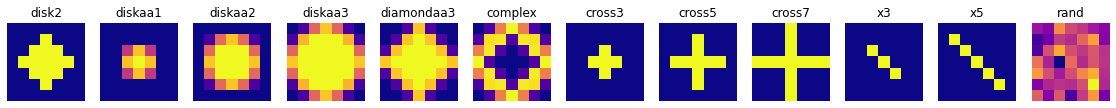

In [2]:
sel_images = os.listdir('out/selems')
plt.subplots(figsize=(200, 200))
for i, sel_image in enumerate(sel_images):
    plt.subplot(1, len(sel_images) * 10, i + 1)
    plt.imshow(image.imread('out/selems/' + sel_image))
    plt.title(sel_image[:-4])
    plt.axis('off')
plt.show()

In [5]:
def plot_filters(layer_name, var_name, layers, sel_idx, op, grid, fig, row, n_filters):
    neg_weights = 1 if layer_name == "pconv" else ops[n_filters][op]
    l1_name = [ x for x in layers.keys() if f"{layer_name}1" in x ][0]
    l1 = layers[f"{l1_name}/weights/filter"][()] * (-1 + 2 * neg_weights)

    start_column = n_padding_column + global_column_size * sel_idx
    column_size = 1 if n_filters == 2 else 2 

    fig.add_subplot(grid[row, start_column:start_column + column_size], **plot_params)
    plt.imshow(l1.squeeze(), cmap='plasma')
    plt.title(f"{layers[l1_name][f'weights/{var_name}'][()].squeeze():.2f}")

    if n_filters == 2:
        neg_weights = 0 if layer_name == "pconv" else neg_weights
        l2_name = [ x for x in layers.keys() if f"{layer_name}2" in x ][0]
        l2 = layers[f"{l2_name}/weights/filter"][()] * (1 - 2 * neg_weights)

        fig.add_subplot(grid[row, start_column + 1: start_column + 2], **plot_params)
        plt.imshow(l2.squeeze(), cmap='plasma')
        plt.title(f"{layers[l2_name][f'weights/{var_name}'][()].squeeze():.2f}")

In [6]:
def plot_lmorph(**kwargs):
    plot_filters("lm", "p", **kwargs)

def plot_smorph(**kwargs):
    plot_filters("sm", "alpha", **kwargs)

def plot_pconv(**kwargs):
    plot_filters("pconv", "p", **kwargs)

def print_meta(path, op, loss, n=None, current_loss=None, current_epoch=None):
    print(f"{'operation:':<15} {op}")
    with h5py.File(f"{path}/vis/meta.h5", "r") as file:
        for key in meta_details:
            print(f"{key + ':':<15} {file[key][()]}")

        print()
        print(f"{'end_epoch' + ':':<15} {file['end_epoch'][()]}")
        print(f"{'end_reason' + ':':<15} {file['end_reason'][()]}")
        print(f"{'attained loss:':<15} {loss}")
        print()
        
        if n != None:
            print(f"{'current_loss' + ': ':<15} {current_loss}")
            print(f"{'current_epoch' + ': ':<15} {current_epoch}")
            

net_plots = { "lmorphnet_double": plot_lmorph,
              "pconvnet_double": plot_pconv,
              "smorphnet_double": plot_smorph,
              "lmorphnet": plot_lmorph,
              "pconvnet": plot_pconv,
              "smorphnet": plot_smorph }

In [8]:
# Creating the global grid
def init(nb_rows, coeff=2):
    fig = plt.figure(constrained_layout=False,
                     figsize=(1 + nb_rows, coeff * (n_padding_column + len(selems) * global_column_size)),
                     dpi=50)
    grid = fig.add_gridspec(nrows=1 + nb_rows,
                            ncols=n_padding_column + len(selems) * global_column_size,
                            width_ratios=width_ratios,
                            left=0, right=2)

    # Filling selem row
    for i, sel_image in enumerate(selems):
        left_border = n_padding_column + i * global_column_size
        right_border = left_border + max_n_filter
        fig.add_subplot(grid[0, left_border:right_border], **plot_params)
        plt.imshow(image.imread(f"out/selems/{sel_image}.png"))
        plt.title(sel_image)

    params = { "grid": grid,
               "fig": fig,
               "row": 1 }
    
    return fig, grid, params

In [9]:
def plot(net_list, row, params, n_filters, run=0):
    params["n_filters"] = n_filters

    for net in net_list:
        fig.add_subplot(grid[row:row + len(ops[n_filters].keys()), 0],
                        frameon=False,
                        **plot_params)
        plt.ylabel(net, fontweight='bold', fontsize=20)

        for op in ops[n_filters].keys():
            params["op"] = op

            fig.add_subplot(grid[row:row + 1, 1], frameon=False, **plot_params)
            plt.ylabel(op, fontsize=15)
            for sel_idx, sel in enumerate(selems):
                path = f"out/mnist_{net}_mse_{op}_{sel}_{run}"
                n_batches = len(os.listdir(f"{path}/vis/batches/"))

                with h5py.File(f"{path}/vis/batches/{n_batches - 1:06}.h5", "r") as file:
                    #print_meta(path, op, file['logs/loss'][()])
                    net_plots[net](layers=file['layers'], sel_idx=sel_idx, **params)

            row += 1
            params["row"] = row

    return row, params

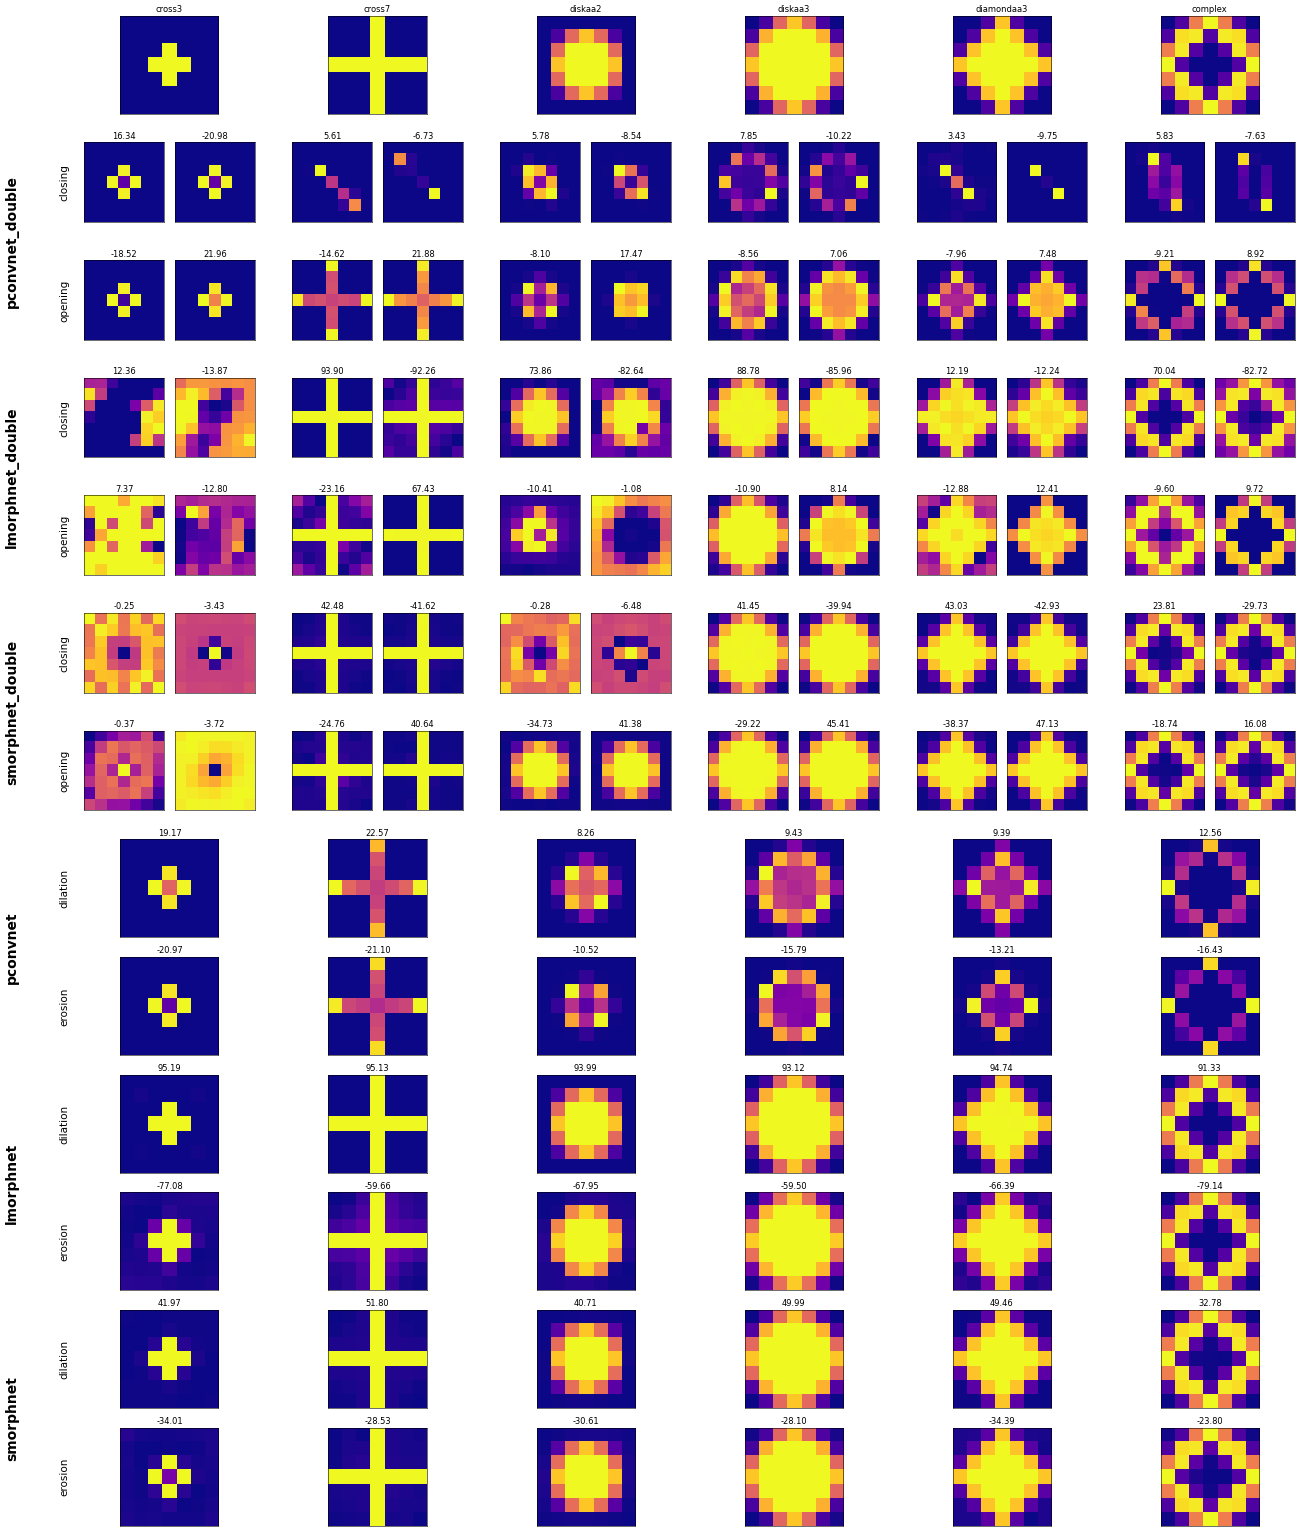

In [10]:
fig, grid, params = init(len(dnets) * len(dop) + len(snets) * len(sop))

row = 1

for n_filters, net_list in nets.items():
    row, params = plot(net_list, row, params, n_filters, 9)

plt.show()

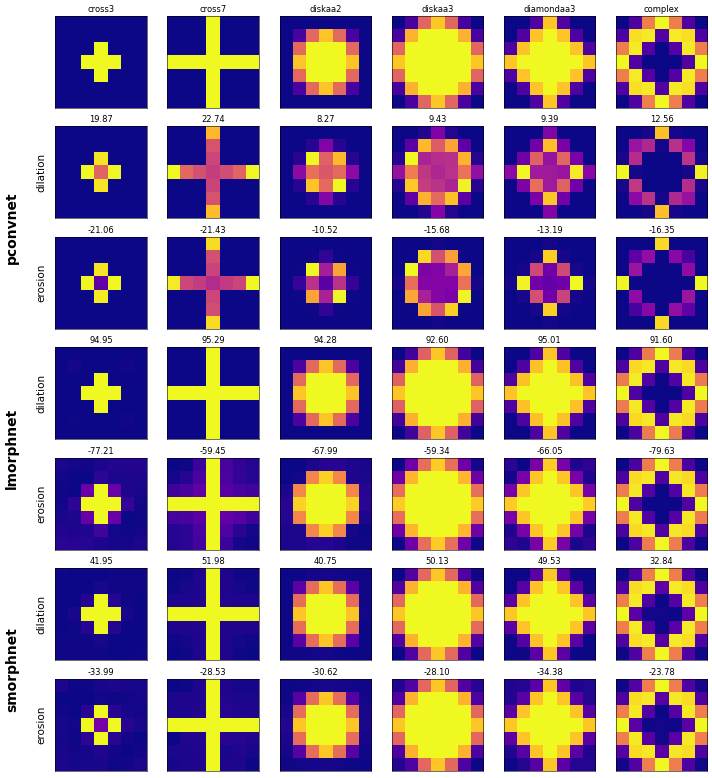

In [11]:
fig, grid, params = init(len(snets) * len(sop), coeff=1)

plot(snets, 1, params, 1)

plt.show()

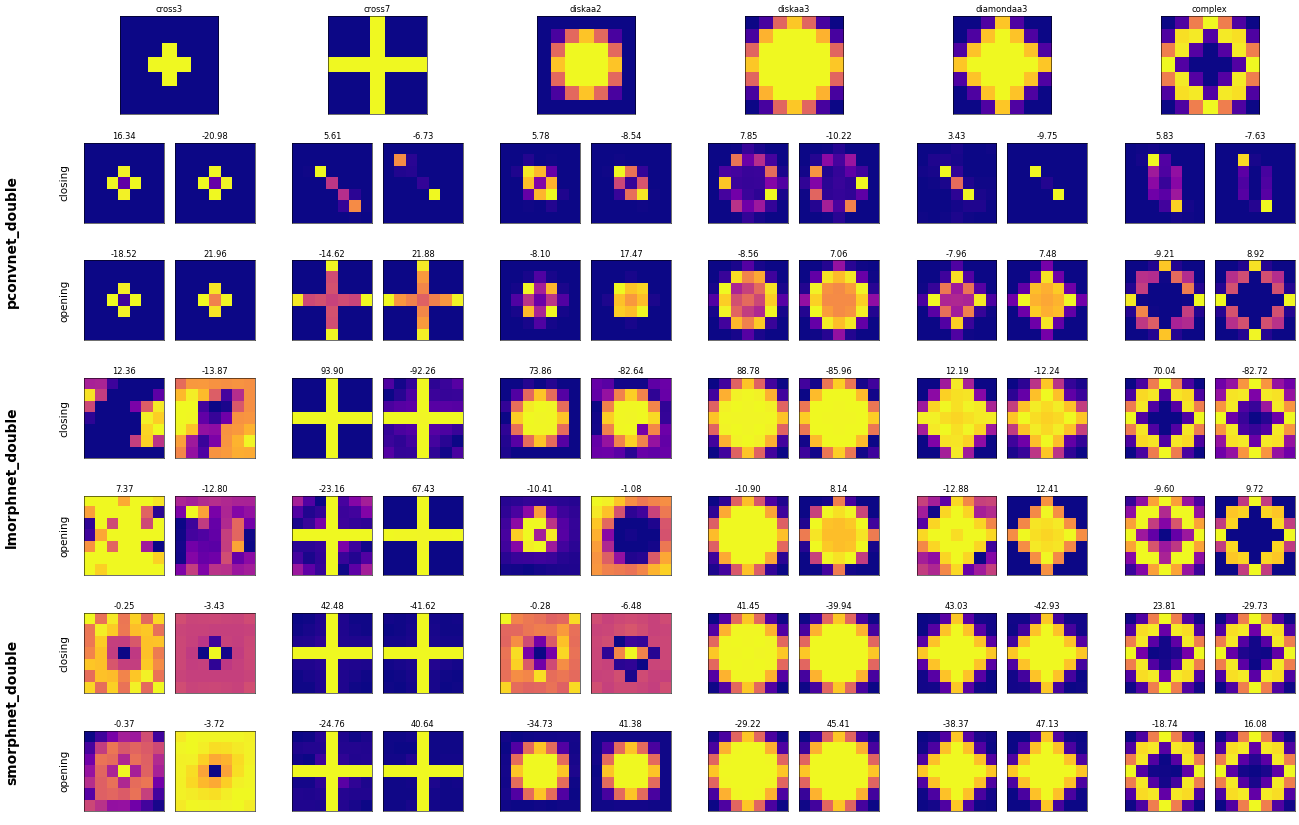

In [323]:
fig, grid, params = init(2 * (len(dnets) * len(dop)))

plot(dnets, 1, params, 2, 9)

plt.show()

In [348]:
def update(x, n_filters, op, var_name, layer_name, path):
    fig = plt.figure()
    with h5py.File(f"{path}/vis/batches/{x:06}.h5", "r") as file:
        neg_weights = 1 if layer_name == "pconv" else ops[n_filters][op]
        l1_name = [ x for x in file['layers'].keys() if f"{layer_name}1" in x ][0]
        l1 = file['layers'][f"{l1_name}/weights/filter"][()] * (-1 + 2 * neg_weights)

        pfound = file['layers'][l1_name][f'weights/{var_name}'][()].squeeze()
        if pfound != 0:
            filterfound = np.log(l1.squeeze()) / pfound
        else:
            filterfound = l1.squeeze()
        ax = fig.add_subplot(1, n_filters, 1)
        p = ax.imshow(filterfound, cmap='plasma')
        ax.set_title(f"{pfound:.2f}")
        ax.axis('off')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(p, cax=cax)

        if n_filters == 2:
            neg_weights = 0 if layer_name == "pconv" else neg_weights
            l2_name = [ x for x in file['layers'].keys() if f"{layer_name}2" in x ][0]
            l2 = file['layers'][f"{l2_name}/weights/filter"][()] * (1 - 2 * neg_weights)

            ax = fig.add_subplot(1, 2, 2)
            p = ax.imshow(l2.squeeze(), cmap='plasma')
            plt.title(f"{file['layers'][l2_name][f'weights/{var_name}'][()].squeeze():.2f}")
            ax.axis('off')
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(p, cax=cax)

        plt.show()

        sb1_name = [ x for x in file['layers'].keys() if "sb" in x ][0]
        print(f"bias: {file['layers'][f'{sb1_name}/weights/bias'][()].squeeze()}")
        print(f"weight: {file['layers'][f'{sb1_name}/weights/weight'][()].squeeze()}")
        if x != 0:
            print(f"loss: {file['logs/loss'][()].squeeze()}")
        else:
            print(f"loss: inf")

def evolution(run, net, op, sel):
    path = f"out/mnist_{net}_mse_{op}_{sel}_{run}"
    n_batches = len(os.listdir(f"{path}/vis/batches/"))

    kwargs = { "n_filters": 1 if net in snets else 2,
               "op": op,
               "var_name": [ name for n, name in var_names.items() if n in net ][0],
               "layer_name": [ name for n, name in layer_names.items() if n in net ][0],
               "path": path }
    
    interact(lambda x : update(x, **kwargs), x=widgets.IntSlider(min=0, max=n_batches - 1, step=1, value=0))

In [349]:
evolution(5, "pconvnet", "dilation", "diskaa3")

interactive(children=(IntSlider(value=0, description='x', max=810), Output()), _dom_classes=('widget-interact'…

In [174]:
def get_info(run, net, op, sel, n=None):
        path = f"out/mnist_{net}_mse_{op}_{sel}_{run}"
        n_batches = len(os.listdir(f"{path}/vis/batches/"))

        with h5py.File(f"{path}/vis/batches/{n_batches - 1:06}.h5", "r") as file:
            loss = file['logs/loss'][()]
            if n == None:
                print_meta(path, op, loss)
                return

        with h5py.File(f"{path}/vis/batches/{n:06}.h5", "r") as file:
            print_meta(path, op, loss, n, file['logs/loss'][()], file['logs/current_epoch'][()] - 1)

In [324]:
get_info(12, "smorphnet_double", "opening", "diskaa3")

operation:      opening
batch_size:     32
dataset:        mnist
end_epoch:      41
end_reason:     No improvement to validation loss in 10 epochs, terminating.
loss:           mse
max_epochs:     1000
model:          models.smorphnet_double
patience:       10
sel_name:       diskaa3
sel_size:       7
vis_freq:       125

end_epoch:      41
end_reason:     No improvement to validation loss in 10 epochs, terminating.
attained loss:  6.630266736603923e-07

